# Simulation of ring network with two interneuron subclasses

This notebook simulates a recurrent network of condunctance-based leaky integrate-and-fire (LIF) neurons with a non-random, ring-like connectivity. Inhibitory neurons are divided in two subclasses, with either a symmetric or neurons under an antysimmetric covariance-based inhibitory spike-timing dependent plasticity (iSTDP) rule. The simuation is based on Brian2 (https://brian2.readthedocs.io).
**This simulation replicates the results in Fig 4 A-D of the main paper**

Running the simulation takes about 25 min on a normal compure, but it might take up to 40 minuts on Google Colab. The simulation results are saved on a binary file.

When using this code, please cite our work.

> Festa, Dylan, Cusseddu, Claudia and Gjorgjieva, Julijana (2024) ‘Structured stabilization in recurrent neural circuits through inhibitory synaptic plasticity’. bioRxiv, p. 2024.10.12.618014. Available at: https://doi.org/10.1101/2024.10.12.618014.

This notebook is intended as a demonstration. Athough it contains the full network training, it does not show the full analysis of the output data and results may differ due to random initialization. It also omits the surround-suppression example. See main README for details.

## Import packages

(if working locally, refer to *installation_instructions.md* to set up the local environment)

In [1]:
# !pip install brian2
# !pip install matplotlib
# import packages
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

import structure 

Set random seed

In [2]:
import random
tseed = random.randint(0, 10000)
random.seed(tseed)
np.random.seed(tseed)
print(f"seed: {tseed}")

seed: 2012


## Auxiliary functions that define the ring connectivity structure

## Network and iSTDP parameters

In [3]:
NE = 800         # Number of excitatory cells
NP = 100         # number of PV cells (symmetric iSTDP)
NS = 100         # number of SST cells (antisymmetric iSTDP)

# simulation time
time_warmup = 3.0 # Warmup time (seconds)
time_training = 1500.0 # Simulation time (seconds)
time_checkspikes = 180.0 # record spikes of exc population here

# ###########################################
# Neuron model
# ###########################################
tau_ampa = 5.0 # Glutamatergic synaptic time constant (ms)
tau_gaba = 10.0 # GABAergic synaptic time constant (ms)
gl = 10.0
el = -60.0
er = -80.0
vt = -50.0
memc = 200.0  # Membrane capacitance
# backgound currents
bg_current_e = 1000.0 # External current (pA)
bg_current_p = 0.0
bg_current_s = 0.0
# noisy input for exc
n_input_e = 200
rate_input_e = 80 # (Hz)
strength_input_e = 1.0 # (mV)
# noisy input for PV
n_input_p = 200
rate_input_p = 40 # (Hz)
strength_input_p = 1.0 # (mV)
# noisy input for SST
n_input_s = 200
rate_input_s = 40 # (Hz)
strength_input_s = 1.0 # (mV)
    
# connection sparseness (inh. only)
connprob_sp = 0.9
connprob_ss = 0.9
connprob_ps = 0.9
connprob_pp = 0.9
# ring parameters (lower is broader)
k_ring_ee=10.0 
k_ring_ep=5.0 
k_ring_es=10.0 
# connection weights
w_ee_sum = 145.0 # exc to exc, SUM
w_ep_sum,w_es_sum = 145.0,145.0 # exc to inh SUM
w_ps,w_sp = 1.0,1.0
w_ss,w_pp = 2.5,2.5
w_pe,w_se= 3.0,3.0 # the plastic ones
# Maximum inhibitory weight
weigh_max = 80

# STDP parameters for PV to exc
A0learn_p = 2E-3
theta_p = -1.0
gamma_p = 20.0
alpha_pre_p = -0.2
alpha_post_p = 1.0
tauplus_stdp_p = 30.0    # STDP time constant (ms)

# STDP parameters for SST to exc
A0learn_s = 1E-3
theta_s = -1.0
gamma_s = 1.0
alpha_pre_s = -0.2
alpha_post_s = 1.0
tauplus_stdp_s = 30.0    # STDP time constant (ms)

# Simulation details
save_id = 'ring_structure_two_interneurons'

## Network simulation code

The block below runs the full network simulation in Brian2. Note that the iSTDP rule is defined by the equations in `eq_on_pre` and `eq_on_post`, corresponding to Eq 7 in the publication.

**The simulation takes over 50 min on Google Colab, and 20 to 30 min on a personal computer**

In [4]:
print(f'NE is {NE}, NP is {NP}, NS is {NS}')

eqs_neurons_e='''
input_contrast : 1
dv/dt=(-(gl*nsiemens)*(v-el*mV)-(g_ampa*v+g_gaba*(v-er*mV))+bg_current_e*pA)/(memc*pfarad) : volt (unless refractory)
dg_ampa/dt = -g_ampa/(tau_ampa*ms) : siemens
dg_gaba/dt = -g_gaba/(tau_gaba*ms) : siemens
'''

eqs_neurons_p='''
dv/dt=(-(gl*nsiemens)*(v-(el*mV))-(g_ampa*v+g_gaba*(v-(er*mV)))+bg_current_p*pA)/(memc*pfarad) : volt (unless refractory)
dg_ampa/dt = -g_ampa/(tau_ampa*ms) : siemens
dg_gaba/dt = -g_gaba/(tau_gaba*ms) : siemens
'''

eqs_neurons_s='''
dv/dt=(-(gl*nsiemens)*(v-(el*mV))-(g_ampa*v+g_gaba*(v-(er*mV)))+bg_current_s*pA)/(memc*pfarad) : volt (unless refractory)
dg_ampa/dt = -g_ampa/(tau_ampa*ms) : siemens
dg_gaba/dt = -g_gaba/(tau_gaba*ms) : siemens
'''

# ###########################################
# Initialize neuron group
# ###########################################
Pe = NeuronGroup(NE, model=eqs_neurons_e, threshold='v > (vt*mV)',
                 reset='v=(el*mV)', refractory=5*ms, method='euler')
Pp = NeuronGroup(NP, model=eqs_neurons_p, threshold='v > (vt*mV)',
                 reset='v=(el*mV)', refractory=5*ms, method='euler')
Ps = NeuronGroup(NS, model=eqs_neurons_s, threshold='v > (vt*mV)',
                 reset='v=(el*mV)', refractory=5*ms, method='euler')

PIe = PoissonInput(Pe, 'g_ampa', n_input_e, rate_input_e*Hz, weight=strength_input_e*nS)
PIp = PoissonInput(Pp, 'g_ampa', n_input_p, rate_input_p*Hz, weight=strength_input_p*nS)
PIs = PoissonInput(Ps, 'g_ampa', n_input_s, rate_input_s*Hz, weight=strength_input_s*nS)

# ##########################################
# Connecting the network
# ###########################################

# exc to exc and to inh
con_ee = Synapses(Pe, Pe,model='w:1', on_pre='g_ampa += w*nS') 
con_ep = Synapses(Pe, Pp,model='w:1', on_pre='g_ampa += w*nS')
con_es = Synapses(Pe, Ps,model='w:1', on_pre='g_ampa += w*nS')
# inh to inh 
con_ps = Synapses(Pp, Ps, on_pre='g_gaba += w_ps*nS')
con_sp = Synapses(Ps, Pp, on_pre='g_gaba += w_sp*nS')
con_pp = Synapses(Pp, Pp, on_pre='g_gaba += w_pp*nS')
con_ss = Synapses(Ps, Ps, on_pre='g_gaba += w_ss*nS')


# ###########################################
# Inhibitory to inhibitory connections
# ###########################################
con_sp.connect(p=connprob_sp)
con_ps.connect(p=connprob_ps)
con_pp.connect(p=connprob_pp)
con_ss.connect(p=connprob_ss)


# ###################################################
# Excitatory connections implement the ring structure
# ##################################################

# exc to exc
idxee_pre,idxee_post,wvals_ee = structure.make_ring_pre_post_fixedsum_list(
    NE,NE,w_ee_sum,k_ring_ee,w_thresh=0.001,avoid_self_connections=True)
con_ee.connect(i=idxee_pre,j=idxee_post)
con_ee.w = wvals_ee

# exc to pv
idxep_pre,idxep_post,wvals_ep = structure.make_ring_pre_post_fixedsum_list(
    NE,NP,w_ep_sum,k_ring_ep,w_thresh=0.001,avoid_self_connections=False)
con_ep.connect(i=idxep_pre,j=idxep_post)
con_ep.w = wvals_ep

# exc to sst
idxes_pre,idxes_post,wvals_es = structure.make_ring_pre_post_fixedsum_list(
    NE,NS,w_es_sum,k_ring_es,w_thresh=0.001,avoid_self_connections=False)
con_es.connect(i=idxes_pre,j=idxes_post)
con_es.w = wvals_es

# ###########################################
# Inhibitory Plasticity
# ###########################################
A0_p = 0.0 # start with no learning
A0_s = 0.0 # start with no learning

# derived parameters
tauminus_stdp_p = gamma_p*tauplus_stdp_p
tauminus_stdp_s = gamma_s*tauplus_stdp_s

# NOT scaled by A0 here (since it controls learning on/off)
Aplus_p = float(1/tauplus_stdp_p)*1E3 # time was in ms, needs to be seconds
Aminus_p = float(theta_p/tauminus_stdp_p)*1E3
print(f"Aplus_p: {Aplus_p:2f}; Aminus_p: {Aminus_p:2f}")

Aplus_s = float(1/tauplus_stdp_s)*1E3
Aminus_s = float(theta_s/tauminus_stdp_s) *1E3
print(f"Aplus_s: {Aplus_s:2f}; Aminus_s: {Aminus_s:2f}")

# modify to let the SST kernel not perfectly antisymmetric
# if amp_scale = 1, then no change
modify_amplitude = True 
if modify_amplitude:
    amp_scale = 10
    Aplus_s_new = amp_scale * Aplus_s
    tauplus_stdp_s_new_ms = (-Aminus_s * tauminus_stdp_s) / Aplus_s_new 
    # overwrite the original values
    Aplus_s = float(Aplus_s_new)
    tauplus_stdp_s = float(tauplus_stdp_s_new_ms)

    area_pos = Aplus_s * tauplus_stdp_s         
    area_neg = Aminus_s * tauminus_stdp_s 
    print(f"area_pos: {area_pos:2f}; area_neg: {area_neg:2f}")

# simple traces for pre- and postsynaptic activity
# (that need to be rescaled)

eqs_stdp_inhib_p = '''
w : 1
dtrace_pre_plus/dt=-trace_pre_plus/(tauplus_stdp_p*ms) : 1 (event-driven)
dtrace_pre_minus/dt=-trace_pre_minus/(tauminus_stdp_p*ms) : 1 (event-driven)
dtrace_post_plus/dt=-trace_post_plus/(tauplus_stdp_p*ms) : 1 (event-driven)
dtrace_post_minus/dt=-trace_post_minus/(tauminus_stdp_p*ms) : 1 (event-driven)
'''

con_pe = Synapses(Pp, Pe, model=eqs_stdp_inhib_p,
    on_pre='''
        trace_pre_plus += 1.0
        trace_pre_minus += 1.0
        w = clip(w + A0_p*(alpha_pre_p + Aplus_p*trace_post_plus + Aminus_p*trace_post_minus), 0, weigh_max)
        g_gaba += w*nS''',
    on_post='''
        trace_post_plus += 1.0
        trace_post_minus += 1.0
        w = clip(w + A0_p*(alpha_post_p + Aplus_p*trace_pre_plus + Aminus_p*trace_pre_minus), 0, weigh_max)''')
con_pe.connect()
con_pe.w = w_pe

    
eqs_stdp_inhib_s = '''
w : 1
dtrace_plus/dt=-trace_plus/(tauplus_stdp_s*ms) : 1 (event-driven)
dtrace_minus/dt=-trace_minus/(tauminus_stdp_s*ms) : 1 (event-driven)
'''

con_se = Synapses(Ps, Pe, model=eqs_stdp_inhib_s,
    on_pre='''
        trace_plus += 1.0
        w = clip(w + A0_s*(alpha_pre_s + Aminus_s*trace_minus), 0, weigh_max)
        g_gaba += w*nS''',
    on_post='''
        trace_minus += 1.0
        w = clip(w + A0_s*(alpha_post_s + Aplus_s*trace_plus), 0, weigh_max)''')
con_se.connect()
con_se.w = w_se

# ###########################################
# Setting up monitors
# ###########################################

# population rates
pop_re_mon = PopulationRateMonitor(Pe)
pop_rp_mon = PopulationRateMonitor(Pp)
pop_rs_mon = PopulationRateMonitor(Ps)
    
# exc spikes
spk_e_mon = SpikeMonitor(Pe)
# pv spikes
spk_p_mon = SpikeMonitor(Pp)
# sst spikes
spk_s_mon = SpikeMonitor(Ps)
    
spk_e_mon.active=False
spk_p_mon.active=False
spk_s_mon.active=False

pop_re_mon.active=False
pop_rp_mon.active=False
pop_rs_mon.active=False

NE is 800, NP is 100, NS is 100


WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


expected_sum: 127.32395447351627
expected_sum: 15.915494309189533
expected_sum: 15.915494309189533
Aplus_p: 33.333333; Aminus_p: -1.666667
Aplus_s: 33.333333; Aminus_s: -33.333333
area_pos: 1000.000000; area_neg: -1000.000000


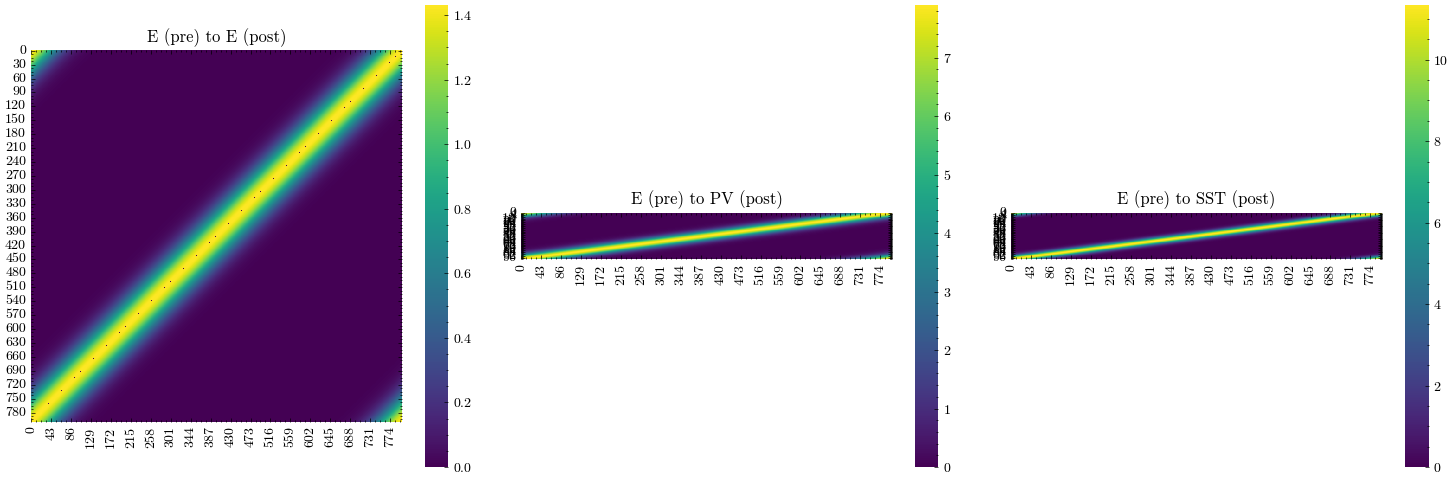

In [5]:
ext_ext_init_weights = np.zeros((NE, NE))
for i in range(len(idxee_pre)):
    ext_ext_init_weights[idxee_pre[i], idxee_post[i]] = wvals_ee[i]
    
ext_pv_init_weights = np.zeros((NE, NP))
for i in range(len(idxep_pre)):
    ext_pv_init_weights[idxep_pre[i], idxep_post[i]] = wvals_ep[i]

ext_sst_init_weights = np.zeros((NE, NS))
for i in range(len(idxes_pre)):
    ext_sst_init_weights[idxes_pre[i], idxes_post[i]] = wvals_es[i]

# similar to the layout (in terms of rotation) with Figure 4
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.heatmap(np.rot90(ext_ext_init_weights), ax=ax[0], cmap='viridis', cbar=True, square=True)
sns.heatmap(np.rot90(ext_pv_init_weights), ax=ax[1], cmap='viridis', cbar=True, square=True)
sns.heatmap(np.rot90(ext_sst_init_weights), ax=ax[2], cmap='viridis', cbar=True, square=True)
ax[0].set_title('E (pre) to E (post)')
ax[1].set_title('E (pre) to PV (post)')
ax[2].set_title('E (pre) to SST (post)')
fig.tight_layout()
fig.savefig(f"../Figures/replicate_ring_structure_initial_weights_seed{tseed}.png", bbox_inches='tight', dpi=300)

tau_plus_p: 30.0; tau_minus_p: 600.0; tau_plus_s: 3.0; tau_minus_s: 30.0
I_pv: 0.000000; I_sst: -0.003663


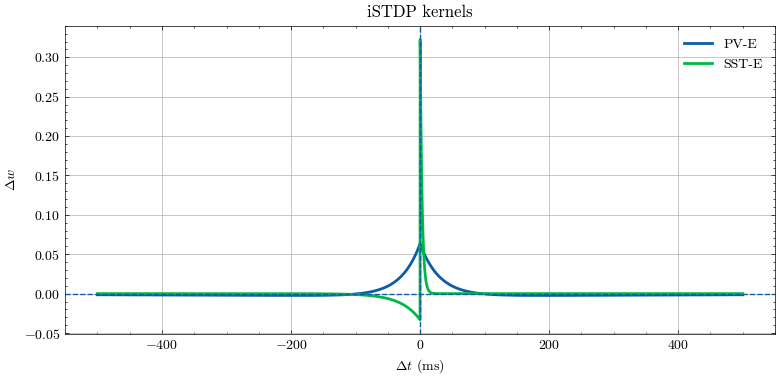

In [6]:
tau_plus_p = tauplus_stdp_p   
tau_minus_p = tauminus_stdp_p
tau_plus_s = tauplus_stdp_s        
tau_minus_s = tauminus_stdp_s

print(f"tau_plus_p: {tau_plus_p}; tau_minus_p: {tau_minus_p}; tau_plus_s: {tau_plus_s}; tau_minus_s: {tau_minus_s}")

def kernel_pv(dt_ms):
    return A0learn_p * (Aplus_p * np.exp(-np.abs(dt_ms) / tau_plus_p)
                        + Aminus_p * np.exp(-np.abs(dt_ms) / tau_minus_p))

def kernel_sst(dt_ms):
    out = np.zeros_like(dt_ms, dtype=float)
    pos = dt_ms > 0
    neg = ~pos
    out[pos] = A0learn_s * (Aplus_s  * np.exp(-dt_ms[pos] / tau_plus_s))
    out[neg] = A0learn_s * (Aminus_s * np.exp(+dt_ms[neg] / tau_minus_s))  
    return out

def remove_near_zero(lst, eps=1e-8):
    """
    """
    return np.array([x for x in lst if abs(x) > eps])

dt_ms_test = np.linspace(-10000, 10000, 1000001)
dt_ms_show = np.linspace(-500, 500, 10001)

kpv_test = kernel_pv(dt_ms_test)
ksst_test = kernel_sst(remove_near_zero(dt_ms_test))

kpv  = kernel_pv(dt_ms_show)
ksst = kernel_sst(remove_near_zero(dt_ms_show))

# half area should be positive and half negative and roughly match in magnitude
I_pv  = np.trapz(kernel_pv(dt_ms_test), dt_ms_test)
I_sst = np.trapz(kernel_sst(dt_ms_test), dt_ms_test)
print(f"I_pv: {I_pv:2f}; I_sst: {I_sst:2f}")

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(dt_ms_show, kpv,  lw=2, label='PV-E')
ax.plot(remove_near_zero(dt_ms_show), ksst, lw=2, label='SST-E')
ax.axhline(0, ls='--', lw=1)
ax.axvline(0, ls='--',  lw=1)
ax.set_xlabel(r'$\Delta t$ (ms)')
ax.set_ylabel(r'$\Delta w$')
ax.set_title('iSTDP kernels')
ax.legend()
ax.grid(True)
fig.tight_layout()
fig.savefig(f'../Figures/replicate_ring_structure_istdp_kernels_seed{tseed}.png', bbox_inches='tight', dpi=1000)

## Running the network

In [7]:
# ###########################################
# Run warmup (no plasticity, no recording)
# ###########################################print('Running warmup')
print('Running warmup')
run(time_warmup*second)
print('Warmup done, now running with plasticity')

# ###########################################
# Run with plasticity and monitors, except spiketimes
# ###########################################
A0_p = A0learn_p
A0_s = A0learn_s

pop_re_mon.active=True
pop_rp_mon.active=True
pop_rs_mon.active=True

run(time_training*second, report='text',report_period=60.0*second)

print('weight training complete, now recording spike trains...')

# ###########################################
# Now final run with spiketime recorder
# ###########################################
spk_e_mon.active=True
spk_p_mon.active=True
spk_s_mon.active=True
run(time_checkspikes*second, report='text')

print('******* \nRuns completed, preparing objects to save\n*******')

def fill_like(vec,val):
    n= len(vec)
    return np.full(n,val)
        
    
w_e2e_components = {
    'NE' : NE,
    'con_ee_ijw': np.stack(
            (np.array(con_ee.i),np.array(con_ee.j),np.array(con_ee.w)),axis=-1),
}
w_e2p_components = {
    'NE' : NE,
    'NP':NP,
    'con_ep_ijw': np.stack(
        (np.array(con_ep.i),np.array(con_ep.j),np.array(con_ep.w)),axis=-1),
}
w_p2e_components = {
    'NP':NP,
    'NE':NE,
    'con_pe_ijw': np.stack(
        (np.array(con_pe.i),np.array(con_pe.j),con_pe.w),axis=-1),
    }
w_p2p_components = {
    'NP':NP,
    'con_pp_ijw': np.stack(
            (np.array(con_pp.i),np.array(con_pp.j),fill_like(con_pp.i,w_pp)),axis=-1),
}

w_e2s_components = {
    'NE' : NE,
    'NS':NS,
    'con_es_ijw': np.stack(
        (np.array(con_es.i),np.array(con_es.j),np.array(con_es.w)),axis=-1),
    }
w_s2e_components = {
    'NS':NS,
    'NE':NE,
    'con_se_ijw': np.stack(
        (np.array(con_se.i),np.array(con_se.j),con_se.w),axis=-1),
    }
w_s2s_components = {
    'NS':NS,
    'con_ss_ijw': np.stack(
        (np.array(con_ss.i),np.array(con_ss.j),fill_like(con_ss.i,w_ss)),axis=-1),
    }
w_p2s_components = {
    'NP':NP,
    'NS':NS,
    'con_ps_ijw': np.stack(
        (np.array(con_ps.i),np.array(con_ps.j),fill_like(con_ps.i,w_ps)),axis=-1),
}
w_s2p_components = {
    'NS':NS,
    'NP':NP,
    'con_sp_ijw': np.stack(
        (np.array(con_sp.i),np.array(con_sp.j),fill_like(con_sp.i,w_sp)),axis=-1),
}

# Export population rates
pop_re_times = pop_re_mon.t / second
pop_re_rates = pop_re_mon.smooth_rate(window='gaussian',width=0.05*second) / Hz
pop_rp_times = pop_rp_mon.t / second
pop_rp_rates = pop_rp_mon.smooth_rate(window='gaussian',width=0.05*second) / Hz
pop_rs_times = pop_rs_mon.t / second
pop_rs_rates = pop_rs_mon.smooth_rate(window='gaussian',width=0.05*second) / Hz
    
print('Now saving data on file')

Running warmup
Warmup done, now running with plasticity
Starting simulation at t=3. s for a duration of 1.5 ks
55.8431 s (3%) simulated in 1m 0s, estimated 25m 52s remaining.
109.7896 s (7%) simulated in 2m 0s, estimated 25m 20s remaining.
168.2184 s (11%) simulated in 3m 0s, estimated 23m 45s remaining.
226.4384 s (15%) simulated in 4m 0s, estimated 22m 30s remaining.
287.1591 s (19%) simulated in 5m 0s, estimated 21m 7s remaining.
0.3465481 ks (23%) simulated in 6m 0s, estimated 19m 58s remaining.
0.403569 ks (26%) simulated in 7m 0s, estimated 19m 1s remaining.
0.4615906 ks (30%) simulated in 8m 0s, estimated 18m 0s remaining.
0.522236 ks (34%) simulated in 9m 0s, estimated 16m 51s remaining.
0.5849885 ks (38%) simulated in 10m 0s, estimated 15m 38s remaining.
0.6441191 ks (42%) simulated in 11m 0s, estimated 14m 37s remaining.
0.7058626 ks (47%) simulated in 12m 0s, estimated 13m 30s remaining.
0.7694236 ks (51%) simulated in 13m 0s, estimated 12m 21s remaining.
0.8301241 ks (55%) 

In [8]:
save_dict = { 
        'ne':NE,
        'np':NP,
        'ns':NS,
        'w_e2e_components':w_e2e_components,
        'w_e2p_components':w_e2p_components,
        'w_e2s_components':w_e2s_components,
        'w_p2e_components':w_p2e_components,
        'w_s2e_components':w_s2e_components,
        'w_p2s_components':w_p2s_components,
        'w_s2p_components':w_s2p_components,
        'w_p2p_components':w_p2p_components,
        'w_s2s_components':w_s2s_components,
        'pop_re_times':pop_re_times,
        'pop_re_rates':pop_re_rates,
        'pop_rp_times':pop_rp_times,
        'pop_rp_rates':pop_rp_rates,
        'pop_rs_times':pop_rs_times,
        'pop_rs_rates':pop_rs_rates,
        'spikeindices_e':np.array(spk_e_mon.i),
        'spiketimes_e':np.array(spk_e_mon.t/second),
        'spikeindices_p':np.array(spk_p_mon.i),
        'spiketimes_p':np.array(spk_p_mon.t/second),
        'spikeindices_s':np.array(spk_s_mon.i),
        'spiketimes_s':np.array(spk_s_mon.t/second),
        }

savetemppath = f'brian2network_{save_id}_seed{seed}.pkl'
# # if file exists, create new file with random string added
# while os.path.exists(savetemppath):
#     savetemppath =  f'brian2network_{save_id}_{np.random.randint(1000)}.pkl'
# with open(savetemppath,'wb') as f:
#     pickle.dump(save_dict,f)
print(f'Created temporary file {savetemppath} to store data')

print('******* \n Run completed!\n*******')

Created temporary file brian2network_ring_structure_two_interneurons_seed<function seed at 0x11a194280>.pkl to store data
******* 
 Run completed!
*******


## Results


### Population rates

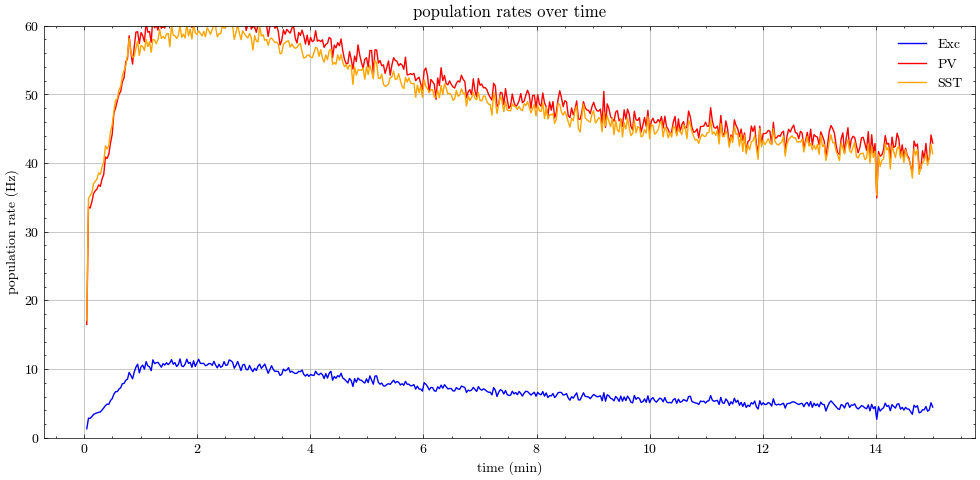

In [9]:
color_e='blue'
color_p='red'
color_s='orange'
nplot = 500
time_end = 15*60 # stop the plot at 15 min
idx_end = np.argmax(pop_re_times>time_end)
idxplot = np.linspace(start=1,stop=idx_end,num=nplot).round().astype(int) # subsample, as data points are too many
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.plot(pop_re_times[idxplot]/60, pop_re_rates[idxplot], label='Exc',color=color_e)
ax.plot(pop_rp_times[idxplot]/60, pop_rp_rates[idxplot], label='PV',color=color_p)
ax.plot(pop_rs_times[idxplot]/60, pop_rs_rates[idxplot], label='SST',color=color_s)
ax.set_xlabel('time (min)')
ax.set_ylabel('population rate (Hz)')
ax.set_title('population rates over time')
ax.legend()
ax.set_ylim([0,60]) # to match the paper
ax.grid(True)
fig.tight_layout()
fig.savefig(f"../Figures/replicate_ring_structure_two_interneurons_pop_rates_seed{tseed}.png", bbox_inches='tight', dpi=300)

This plot shows that excitatory rates are regulated by inhibitory plasticity.

### Normalized connectivity profile



#### Utility functions to average by angular tuning

In [10]:
def unband_and_center(mat, indexes=None):
    nrow, ncol = mat.shape
    if indexes is None:  # only works on square matrices
        indexes = np.arange(ncol)
    assert len(indexes) == nrow, "indexes must have same length as rows of mat"
    assert np.all((0 <= indexes) & (indexes <= ncol-1)), "indexes must be in the range 0:ncol-1"
    inddiff = np.diff(indexes)
    if np.any(inddiff > 1):
        raise ValueError("indexes are not contiguous")
    ret = np.empty((nrow, ncol), dtype=mat.dtype)
    ncenter = ncol // 2 - 1
    for i in range(nrow):
        for j in range(ncol):
            js = (j + indexes[i] ) % ncol
            ret[i, (j + ncenter) % ncol] = mat[i, js]
    return ret

def mean_and_norm(mat):
    ret = np.mean(mat, axis=0)
    ret /= np.max(ret)
    return ret

def mean_cols_nodiagonal(mat):
    nrows, ncols = mat.shape
    ret = np.empty(ncols, dtype=mat.dtype)
    for j in range(ncols):
        ret[j] = np.sum(np.delete(mat[:, j], j))
    ret /= (nrows - 1)
    return ret

def unband_mean_normalize(mat, indexes=None):
    if indexes is None:
        indexes = np.arange(1, mat.shape[1] + 1)
    mat_unband = unband_and_center(mat, indexes)
    means = mean_cols_nodiagonal(mat_unband)
    return means / np.max(means)

#### Convert i,j,w into 2D matrices

In [11]:
w_ee_full = np.zeros((NE,NE),dtype=float)
for (i,j,w) in zip(con_ee.i,con_ee.j,con_ee.w):
    w_ee_full[j,i] = w
w_es_full = np.zeros((NS,NE),dtype=float)
for (i,j,w) in zip(con_es.i,con_es.j,con_es.w):
    w_es_full[j,i] = w
w_se_full = np.zeros((NE,NS),dtype=float)
for (i,j,w) in zip(con_se.i,con_se.j,con_se.w):
    w_se_full[j,i] = w
w_ep_full = np.zeros((NP,NE),dtype=float)
for (i,j,w) in zip(con_ep.i,con_ep.j,con_ep.w):
    w_ep_full[j,i] = w
w_pe_full = np.zeros((NE,NP),dtype=float)
for (i,j,w) in zip(con_pe.i,con_pe.j,con_pe.w):
    w_pe_full[j,i] = w
    
w_ps_full = np.zeros((NS,NP),dtype=float)
for (i,j) in zip(con_ps.i,con_ps.j):
    w_ps_full[j,i] = w_ps
w_sp_full = np.zeros((NP,NS),dtype=float)
for (i,j) in zip(con_sp.i,con_sp.j):
    w_sp_full[j,i] = w_sp
w_pp_full = np.zeros((NP,NP),dtype=float)
for (i,j) in zip(con_pp.i,con_pp.j):
    w_pp_full[j,i] = w_pp
w_ss_full = np.zeros((NS,NS),dtype=float)
for (i,j) in zip(con_ss.i,con_ss.j):
    w_ss_full[j,i] = w_ss

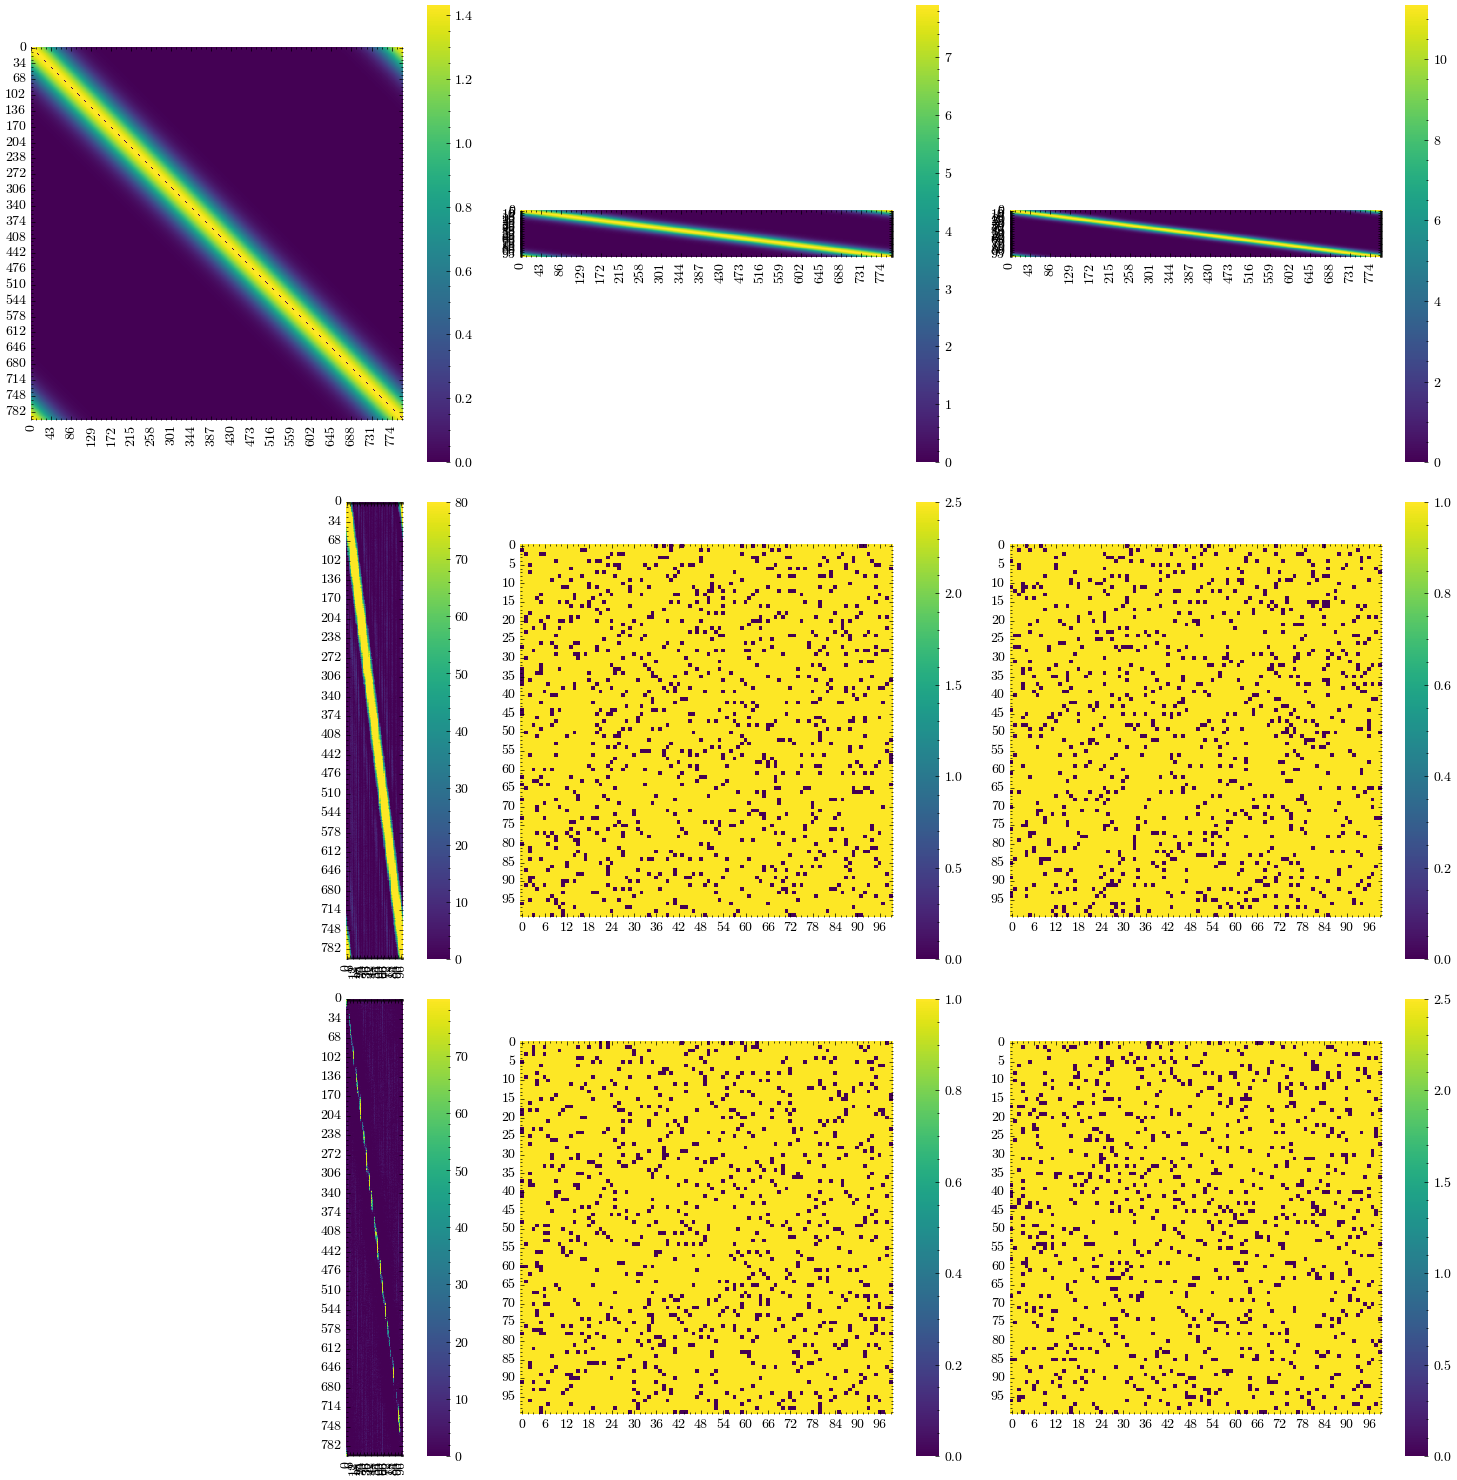

In [12]:
fig, ax = plt.subplots(3,3,figsize=(5*3,5*3))
sns.heatmap(w_ee_full, ax=ax[0,0], cmap='viridis', cbar=True, square=True)
sns.heatmap(w_ep_full, ax=ax[0,1], cmap='viridis', cbar=True, square=True)
sns.heatmap(w_es_full, ax=ax[0,2], cmap='viridis', cbar=True, square=True)

sns.heatmap(w_pe_full, ax=ax[1,0], cmap='viridis', cbar=True, square=True)
sns.heatmap(w_pp_full, ax=ax[1,1], cmap='viridis', cbar=True, square=True)
sns.heatmap(w_ps_full, ax=ax[1,2], cmap='viridis', cbar=True, square=True)

sns.heatmap(w_se_full, ax=ax[2,0], cmap='viridis', cbar=True, square=True)
sns.heatmap(w_sp_full, ax=ax[2,1], cmap='viridis', cbar=True, square=True)
sns.heatmap(w_ss_full, ax=ax[2,2], cmap='viridis', cbar=True, square=True)
fig.tight_layout()
fig.savefig(f"../Figures/replicate_ring_structure_final_weights_seed{tseed}.png", bbox_inches='tight', dpi=300)

#### Plot of connectivity profiles

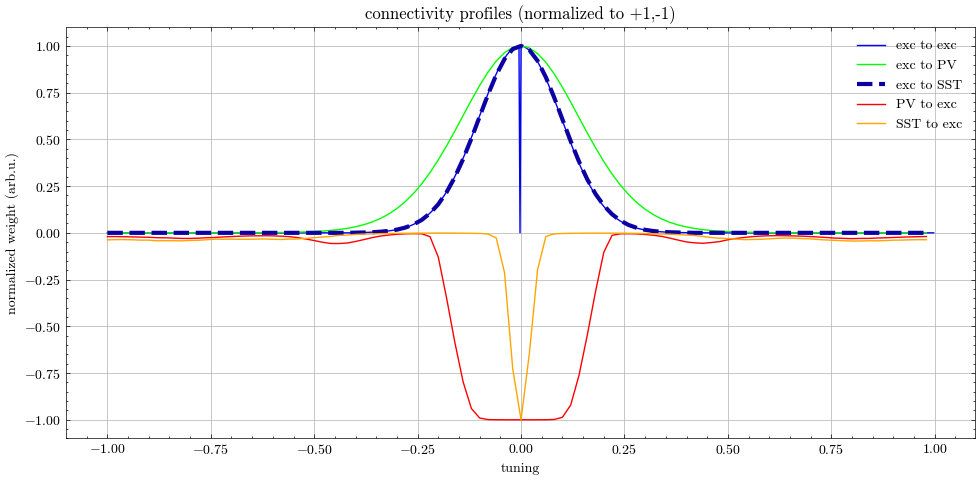

In [13]:
# Shift indexes PV and SST so that they are related to the exc population
shift_idx_sst = np.array(np.linspace(0,NS-1,NE),dtype=int)
shift_idx_pv = np.array(np.linspace(0,NP-1,NE),dtype=int)

tuning_exc_all = np.linspace(-1.0,1.0,NE+1)[0:NE] # because -1 and +1 are the same point
tuning_pv_all = np.linspace(-1.0,1.0,NP+1)[0:NP]
tuning_sst_all = np.linspace(-1.0,1.0,NS+1)[0:NS]

profile_ee=mean_and_norm(unband_and_center(w_ee_full))
profile_pe=mean_and_norm(unband_and_center(w_pe_full,shift_idx_pv))
profile_ep=mean_and_norm(unband_and_center(w_ep_full.transpose(),shift_idx_pv))
profile_se=mean_and_norm(unband_and_center(w_se_full,shift_idx_sst))
profile_es=mean_and_norm(unband_and_center(w_es_full.transpose(),shift_idx_sst))

# Let's plot
color_e_to_e='#0000ff'
color_e_to_pv='#04ff00'
color_e_to_sst='#0d00a3'
color_p='red'
color_s='orange'

fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.plot(tuning_exc_all,profile_ee, label='exc to exc',color=color_e_to_e)
ax.plot(tuning_pv_all,profile_ep, label='exc to PV',color=color_e_to_pv)
ax.plot(tuning_pv_all,profile_es, label='exc to SST',color=color_e_to_sst,linestyle='dashed',linewidth=3)
ax.plot(tuning_pv_all,-profile_pe, label='PV to exc',color=color_p)
ax.plot(tuning_sst_all,-profile_se, label='SST to exc',color=color_s)
ax.set_xlabel('tuning')
ax.set_ylabel('normalized weight (arb.u.)')
ax.set_title('connectivity profiles (normalized to +1,-1)')
ax.legend()
ax.grid(True)
fig.tight_layout()
fig.savefig(f"../Figures/replicate_ring_structure_two_interneurons_connectivity_profiles_seed{tseed}.png", bbox_inches='tight', dpi=300)

As expected from the results on the random network, the PV population (symmetric iSTDP) appears co-tuned with excitation, forming mutual connections. The SST neurons project their connections laterally, instead.

### Shape of effective exc to exc interaction

The effective interaction between excitatory neurons is found by considering the expansion series of the full weight matrix.

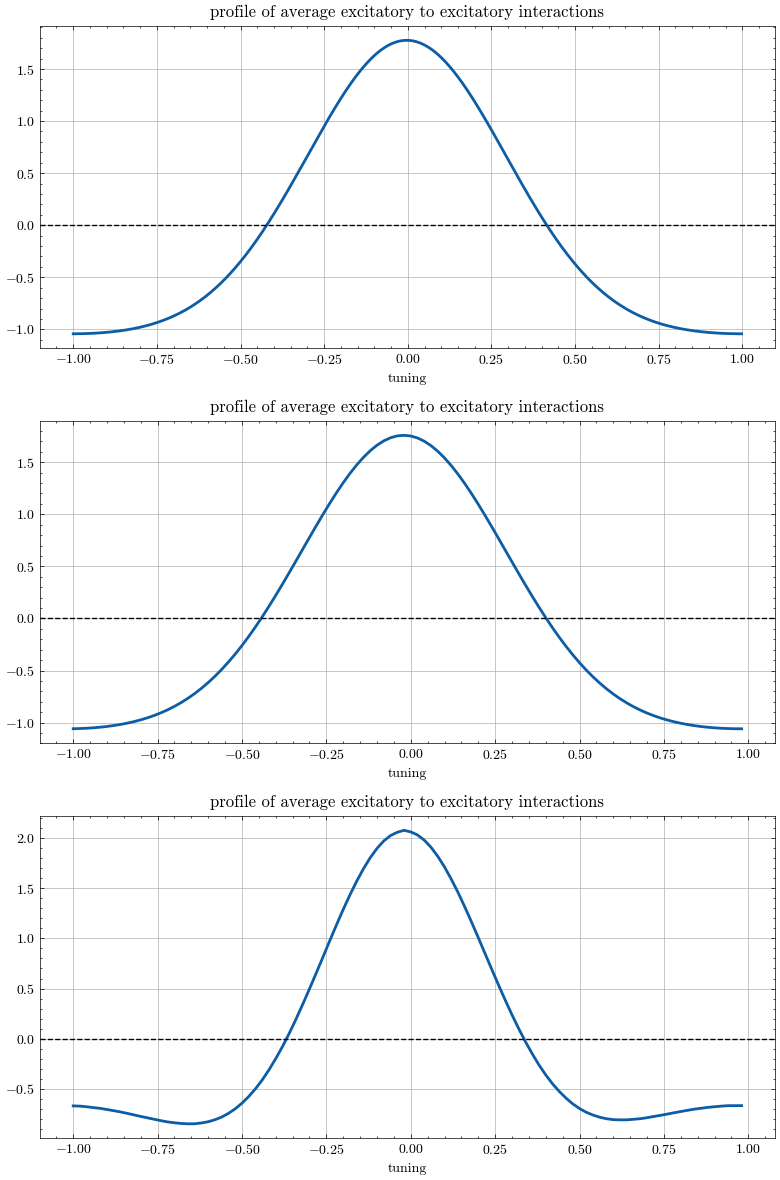

In [14]:
NTOT=NE+NP+NS
idx_e = np.arange(NE)
idx_p = NE+np.arange(NP)
idx_s = NE+NP+np.arange(NS)

w_full = np.zeros((NTOT,NTOT),dtype=float)
w_full[np.ix_(idx_e,idx_e)]=w_ee_full
w_full[np.ix_(idx_p,idx_e)]=w_ep_full
w_full[np.ix_(idx_e,idx_p)]=-w_pe_full
w_full[np.ix_(idx_p,idx_p)]=-w_pp_full

w_full[np.ix_(idx_s,idx_e)]=w_es_full
w_full[np.ix_(idx_e,idx_s)]=-w_se_full
w_full[np.ix_(idx_s,idx_s)]=-w_ss_full

w_full[np.ix_(idx_s,idx_p)]=-w_ps_full
w_full[np.ix_(idx_p,idx_s)]=-w_sp_full

# Just the sum of powers of the weight matrix
w_effective = (np.eye(NTOT) 
              + w_full 
               + w_full @ w_full 
               + w_full @ w_full @ w_full 
               + w_full @ w_full @ w_full @ w_full
               + w_full @ w_full @ w_full @ w_full  @ w_full  
               + w_full @ w_full @ w_full @ w_full  @ w_full @ w_full
)

dict_info = [[idx_e, tuning_exc_all, "excitatory"], [idx_p, tuning_pv_all, "PV"], [idx_s, tuning_sst_all, "SST"]]

fig, ax = plt.subplots(3,1,figsize=(8,4*3))

for index, (idx, tuning_all, label) in enumerate(dict_info):
    w_effective_ee = w_effective[np.ix_(idx, idx)]
    profile_ee_effective=mean_and_norm(unband_and_center(w_effective_ee))
    profile_ee_effective_zscored = (profile_ee_effective - profile_ee_effective.mean()) / profile_ee_effective.std()

    ax[index].plot(tuning_all, profile_ee_effective_zscored, lw=2)
    ax[index].set_xlabel('tuning')
    ax[index].set_title('profile of average excitatory to excitatory interactions')
    ax[index].axhline(0, ls='--', lw=1, color='black')
    ax[index].grid(True)

fig.tight_layout()
fig.savefig(f"../Figures/replicate_ring_structure_two_interneurons_effective_profile_seed{tseed}.png", bbox_inches='tight', dpi=1000)

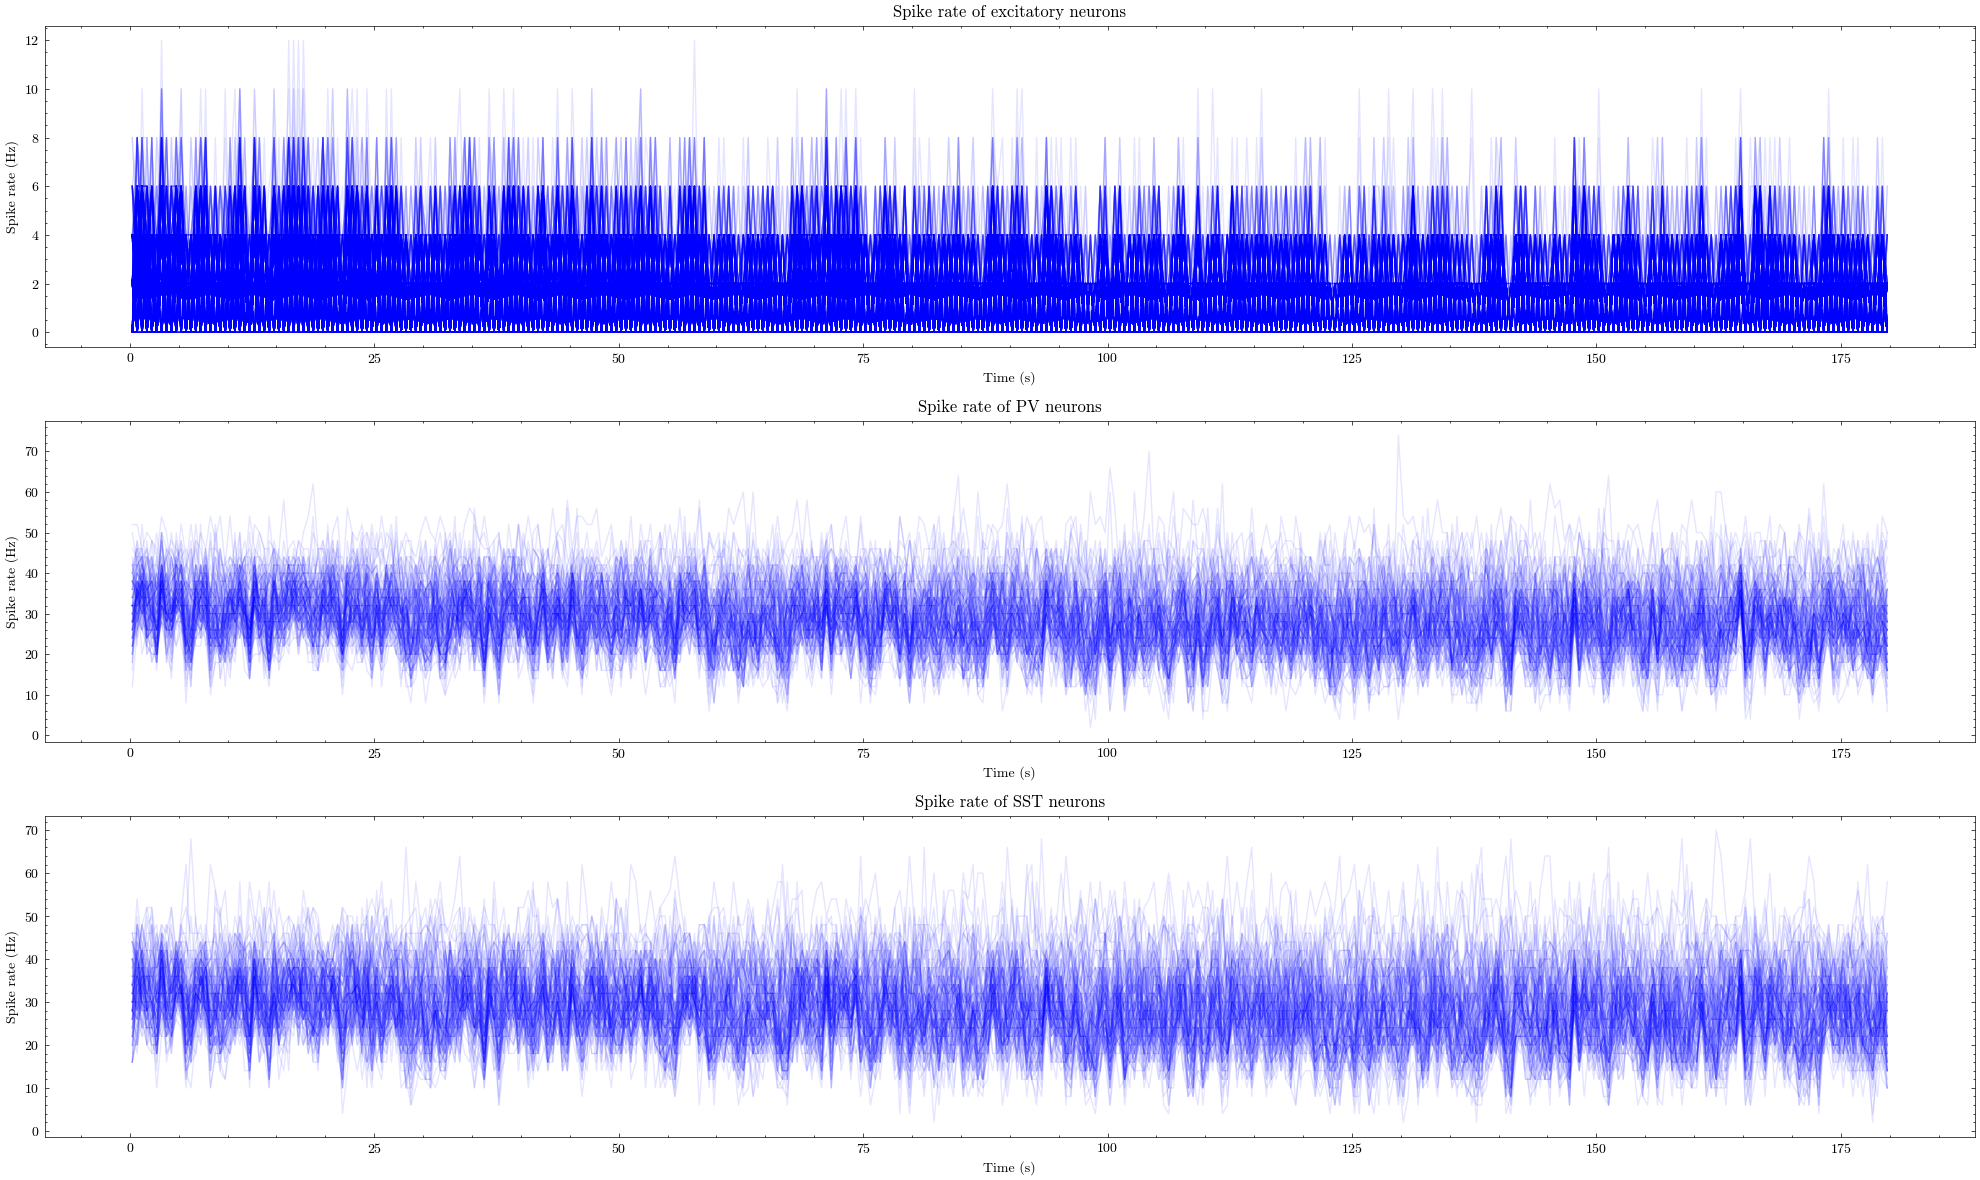

In [15]:
bin_width = 500.0 * 0.001
t_start = 0
t_stop  = time_checkspikes                    
bins    = np.arange(t_start, t_stop + bin_width, bin_width)
t_axis = (bins[:-1] + bin_width/2)

fig, ax = plt.subplots(3,1,figsize=(20,4*3))
dict_info = [[NE, spk_e_mon, "excitatory"], [NP, spk_p_mon, "PV"], [NS, spk_s_mon, "SST"]]
for index, (NUM, spk_mon, spk_name) in enumerate(dict_info):
    for ne_index in range(NUM):
        spike_aligned = np.array(spk_mon.spike_trains()[ne_index]) - time_training - time_warmup
        counts, _ = np.histogram(spike_aligned, bins=bins)
        rate_hz   = counts / bin_width
        ax[index].plot(t_axis, rate_hz, color=color_e, alpha=0.1)
    ax[index].set_xlabel('Time (s)')
    ax[index].set_ylabel('Spike rate (Hz)')
    ax[index].set_title(f'Spike rate of {spk_name} neurons')
    
fig.tight_layout()
fig.savefig(f"../Figures/replicate_ring_structure_two_interneurons_spikes_seed{tseed}.png", bbox_inches='tight', dpi=300)

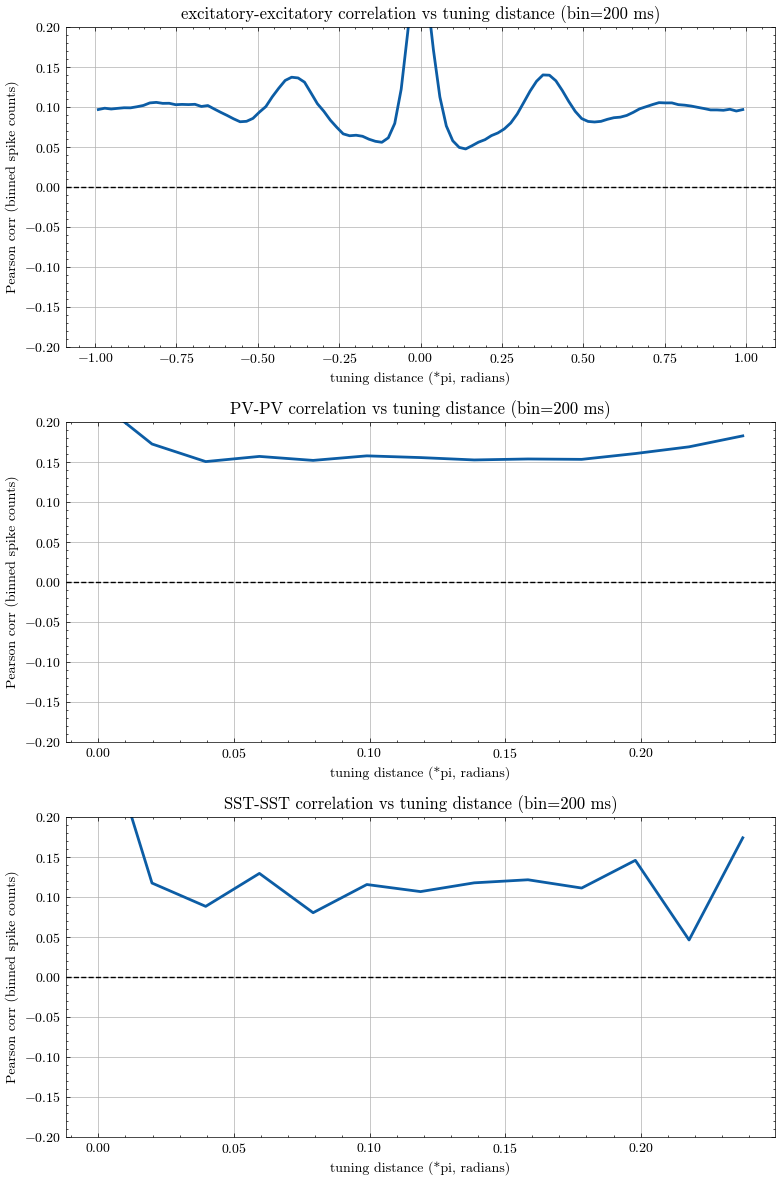

: 

In [ ]:
dict_info = [[NE, spk_e_mon, "excitatory"], [NP, spk_p_mon, "PV"], [NS, spk_s_mon, "SST"]]

fig, ax = plt.subplots(3,1,figsize=(8,4*3))

for index, (NUM, spk_mon, spk_name) in enumerate(dict_info):
    bin_ms = 200.0             
    nbins_distance = 101      
    min_spikes_per_neuron = 1      

    idx_e = np.array(spk_mon.i, dtype=np.int32)
    t_e   = np.array(spk_mon.t/second, dtype=np.float64)

    t1 = float(t_e[-1])                          
    t0 = t1 - float(time_checkspikes)           
    dt = bin_ms / 1000.0
    edges = np.arange(t0, t1 + dt, dt)
    nb = len(edges) - 1

    mask = (t_e >= t0) & (t_e < t1)
    idx_e = idx_e[mask]
    t_e   = t_e[mask]

    counts = np.zeros((nb, NE), dtype=np.float32)
    if len(t_e) > 0:
        bidx = np.floor((t_e - t0) / dt).astype(np.int64)
        np.add.at(counts, (bidx, idx_e), 1.0)

    spike_totals = counts.sum(axis=0)
    keep = spike_totals >= min_spikes_per_neuron
    counts = counts[:, keep]
    kept_idx = np.where(keep)[0]

    mu = counts.mean(axis=0, keepdims=True)
    sd = counts.std(axis=0, ddof=1, keepdims=True)
    good = (sd[0] > 0)
    counts = counts[:, good]
    kept_idx = kept_idx[good]
    Z = (counts - mu[:, good]) / sd[:, good]
    nb_kept = Z.shape[1]

    C = (Z.T @ Z) / (Z.shape[0] - 1)  

    angles_e = structure.assign_angles(NE)                        
    angles_inc = angles_e[kept_idx]                    
    D = np.abs(angles_inc[:, None] - angles_inc[None, :])
    # D = np.minimum(D, 2*np.pi - D)   
    D = (D + np.pi) % (2*np.pi) - np.pi                 

    iu = np.triu_indices(nb_kept, k=1)                  
    d = D[iu]
    c = C[iu]

    edges_d = np.linspace(-np.pi, np.pi, nbins_distance + 1)
    edges_d[-1] = np.nextafter(edges_d[-1], edges_d[-1] + 1)   
    centers = 0.5 * (edges_d[:-1] + edges_d[1:])
    which = np.digitize(d, edges_d) - 1

    profile = np.full(nbins_distance, np.nan, dtype=float)
    for b in range(nbins_distance):
        sel = (which == b) & np.isfinite(c)
        if np.any(sel):
            profile[b] = c[sel].mean()

    ax[index].plot(centers/np.pi, profile, lw=2)
    ax[index].set_xlabel('tuning distance (*pi, radians)')
    ax[index].set_ylabel('Pearson corr (binned spike counts)')
    ax[index].set_title(f'{spk_name}-{spk_name} correlation vs tuning distance (bin={bin_ms:.0f} ms)')
    ax[index].set_ylim([-0.2, 0.2])
    ax[index].axhline(0, ls='--', lw=1, color='black')
    ax[index].grid(True)
    
fig.tight_layout()
fig.savefig(f"../Figures/replicate_ring_structure_two_interneurons_exc_exc_corr_vs_distance_seed{tseed}.png", bbox_inches='tight', dpi=300)